In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Exportar modelos
import pickle
# Pipeline
from sklearn.pipeline import Pipeline
# CV
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import VotingRegressor
# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [15]:
# Cargamos datos
data_actual_original= pd.read_csv('./TRABAJADORES_ACTUALES_MOD_FINAL4.csv', sep='\t')
data_attrition_original = pd.read_csv('./ATTRITION_MOD_FINAL4.csv', sep='\t')

In [16]:
# Eliminar columnas
columns_to_drop = ['id_employee','name', 'involvement', 'performance', 'environment', 'department', 'education', 'education_field',
                   'gender', 'role', 'years_curr_manager','total_working_years', 'last_promotion', 'age']
data_actual_limpio = data_actual_original.drop(columns=columns_to_drop)
data_attrition_limpio = data_attrition_original.drop(columns=columns_to_drop)


## Entrenamiento

In [6]:
# Dividimos en features y target, siendo el target x_e_out [-]
X = data_attrition_limpio.drop(['years_company'], axis = 1)
y = data_attrition_limpio['years_company']
# multiplicamos years_company por 12 para obtener los meses
y = y * 12

# Dividimos entre train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Preparando la validación cruzada
cv = KFold(n_splits=5, shuffle = True, random_state=0)

In [18]:
# Cargamos los modelos pickle que conformarán el ensamble
with open('./JP_10_06_1_XGB_MAE_2-85_R2_0-98.pickle', 'rb') as f:
    xgb = pickle.load(f)
with open('./JP_10_06_1_RIDGE_MAE_26-50_R2_0-61.pickle', 'rb') as f:
    ridge = pickle.load(f)

estimator_ridge = ridge
estimator_xgb = xgb

# Crear el VotingRegressor
voting_regressor = VotingRegressor(
    estimators=[
        ('ridge', estimator_ridge),
        ('xgb', estimator_xgb)
    ]
)

# Entrenar el VotingRegressor
voting_regressor.fit(X_train_scaled, y_train)

# Obtener las predicciones del VotingRegressor
y_pred = voting_regressor.predict(X_test_scaled)

In [20]:
## Exportamos a pickle el scaler
with open('./scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
    

In [11]:
## Exportamos a pickle el voting_regressor

nombre_archivo = './VotingRegressor_scaled.pickle'
modelo = voting_regressor
import pickle
try:
    with open(nombre_archivo, 'wb') as archivo:
        pickle.dump(modelo, archivo)
    print(f"El modelo se ha guardado exitosamente en {nombre_archivo}.")
except IOError:
    print("Error: No se pudo guardar el modelo. Permiso denegado.")
    

El modelo se ha guardado exitosamente en ./VotingRegressor_scaled.pickle.


## Feature importance voting regressor

In [63]:
estimators = voting_regressor.estimators_

# Inicializar una lista para almacenar las importancias de las características de cada modelo
feature_importances = []

# Obtener las importancias de las características de cada modelo y almacenarlas en la lista
for estimator in estimators:
    if hasattr(estimator, 'feature_importances_'):
        feature_importances.append(estimator.feature_importances_)

# Calcular la media de las importancias de las características de todos los modelos
mean_feature_importances = np.mean(feature_importances, axis=0)

# Utilizar la media para interpretar la importancia relativa de las características
print("Media de importancia de características:", mean_feature_importances)

Media de importancia de características: [0.16143066 0.01144143 0.00884414 0.04603199 0.10602067 0.03252601
 0.24605961 0.04430465 0.05745124 0.16451548 0.12137408]


In [47]:
# Representamos las mean_feature_importances en un gráfico de barras con plotly
import plotly.graph_objects as go
# Hacemos un barh con X.columns, mean_feature_importances
fig = go.Figure(go.Bar(
            x=mean_feature_importances,
            y=X.columns,
            orientation='h'))
#X_label Importancia relativa
fig.update_layout(title_text='<b>Feature importances</b>',
                    xaxis_title_text='Importancia relativa',
                    yaxis_title_text='Variables')
# Aumentamos el tamaño vertical y reducimos la anchura
fig.update_layout(autosize=False, width=800, height=900)
# Centramos el título
fig.update_layout(title_x=0.5)
# Añadimos el tamaño de las fuentes de los ejes

fig.update_layout(
    font=dict(
        size=22,
    )
)


# La mostramos
fig.show()



### Extraemos gráficas de error

In [74]:
# Creamos el histograma de errores en plotly
import plotly.express as px
fig = px.histogram(y_pred - y_test, nbins=60, labels={'x':'Error'})
fig.update_layout(title_text='<b>Histograma de errores</b>',
                    xaxis_title_text='Error',
                    yaxis_title_text='Frecuencia')
# Aumentamos el tamaño vertical y reducimos la anchura
fig.update_layout(autosize=False, width=1000, height=500)
# Eliminamos la leyenda
fig.update_layout(showlegend=False)
# Aumentamos el tamaño de la fuente a 20
fig.update_layout(
    font=dict(
        size=20,
    )
)

# Centramos el título
fig.update_layout(title_x=0.5)


In [73]:
# Trazamos la recta de regresión con plotly
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred,
                    mode='markers',
                    name='Predicciones'))
fig.add_trace(go.Scatter(x=y_test, y=y_test,

                    mode='lines',   
                    name='Recta de regresión'))
fig.update_layout(title_text='<b>Recta de regresión</b>',
                    xaxis_title_text='Valores reales',
                    yaxis_title_text='Predicciones')
# Aumentamos el tamaño vertical y reducimos la anchura
fig.update_layout(autosize=False, width=1000, height=500)
# Centramos el título
fig.update_layout(title_x=0.5)
# Añadimos el tamaño de las fuentes de los ejes
fig.update_layout(
    font=dict(
        size=20,
    )
)

# Lo mostramos
fig.show()


### Métricas

In [64]:
train_score = voting_regressor.score(X_train_scaled, y_train)
test_score = voting_regressor.score(X_test_scaled, y_test)
print(train_score)
print(test_score)

0.8872451828129375
0.84577792208433


In [67]:
# Predecir los valores de salida para los datos de test con el mejor modelo
y_pred = voting_regressor.predict(X_test_scaled)
# Redondeamos y_pred
#y_pred = np.round(y_pred)

# Evaluar el rendimiento del mejor modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('RMSE:', np.sqrt(mse))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
#print('Mejores hiperparámetros:', best_params)
metricas = pd.DataFrame({'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae], 'R2': [r2]})
metricas.to_csv('./Métricas/Métricas_votingregressor.csv', index=False)

MSE: 519.5943849551633
RMSE: 22.794613068774897
MAE: 14.426893254707243
R2: 0.84577792208433


In [ ]:
# Calculo la puntuacion train_score y test_score
train_score = voting_regressor.score(X_train_scaled, y_train)
test_score = voting_regressor.score(X_test_scaled, y_test)
# Calvulo la puntuación en validación cruzada
cv_scores = cross_val_score(voting_regressor, X, y, cv=10)
print("Puntuación en entrenamiento:", train_score)
print("Puntuación en prueba:", test_score)
print("Puntuaciones en validación cruzada:", cv_scores)
# Imprimimos la media de cv_scores
print("Media de puntuaciones en validación cruzada:", cv_scores.mean())

# Exportamos a csv train_score, test_score, media de cv_scores
scores = pd.DataFrame({'train_score': [train_score], 'test_score': [test_score], 'cv_scores_mean': [cv_scores.mean()]})
scores.to_csv('./Métricas/Scores_votingregressor.csv', index=False)


Puntuación en entrenamiento: 0.8872451828129375
Puntuación en prueba: 0.84577792208433
Puntuaciones en validación cruzada: [0.89087478 0.83869275 0.7769361  0.7134483  0.84788123 0.85452754
 0.81912396 0.87609723 0.87622074 0.77849338]
Media de puntuaciones en validación cruzada: 0.8272296005657447


### Exportar modelo

In [ ]:
nombre_archivo = './JP_12_06_VotingRegressor.pickle'
modelo = voting_regressor
import pickle
try:
    with open(nombre_archivo, 'wb') as archivo:
        pickle.dump(modelo, archivo)
    print(f"El modelo se ha guardado exitosamente en {nombre_archivo}.")
except IOError:
    print("Error: No se pudo guardar el modelo. Permiso denegado.")

El modelo se ha guardado exitosamente en ./JP_12_06_VotingRegressor.pickle.


### Evaluación de resultados, negativos, gestión de negativos...

In [ ]:
# # Hacemos una predicción de prueba
#y_pred = best_model.predict(X_test)
y_pred

array([ 1.69390315e+02,  6.07996187e+01,  1.19081212e+02,  3.23118454e+01,
        1.08419767e+02,  5.32735180e+01,  1.89805144e+02,  1.60394197e+01,
        1.85400015e+01,  1.99008459e+01,  4.82078909e+01,  1.00265695e+02,
        1.52455605e+01,  1.29082856e+02,  2.25863995e+00,  6.37551933e+01,
        1.11466311e+02,  1.86044316e+01,  5.32523402e+01,  4.60050616e+01,
        7.25062769e+01,  8.79856401e+01,  5.31095327e+01,  7.12937462e+01,
        4.00689752e+01,  9.62072847e+01,  1.41345204e+01,  7.09693219e+01,
        1.91230876e+02,  3.03000954e+00,  8.01262119e+01,  1.54918046e+02,
        2.37376627e+01,  4.87760609e+01,  5.90346108e+01,  4.52405119e+01,
        3.61250449e-01,  5.30150346e+01,  4.89887291e+01,  6.27204083e+01,
        3.01609171e+01,  7.41522501e+01,  1.87693361e+01,  2.46646303e+01,
        8.48778242e+00,  4.15518040e+01,  1.23027269e+02,  7.14880020e+01,
        8.91273548e+00,  2.20273626e+01,  3.45681572e+01,  5.77295611e+01,
        2.17133678e+01,  

In [ ]:
# contamos los valores negativos de LA PREDICCIÓN ORIGINAL BÁSICA
y_pred[y_pred < 0].shape[0]


4

In [ ]:
# Creo un nuevo dataset para predicciones a partir de las filas que tienen attrition = No
data_pred = data_actual_original.copy()
data_pred =data_pred.drop(columns_to_drop, axis = 1)

meses_reales = data_pred['years_company'] *12
data_pred.drop(['years_company'], axis = 1, inplace = True)

data_pred_for_scale = data_pred.copy()


data_pred_scaled = scaler.transform(data_pred_for_scale)

# # # # # Hacemos una predicción con el modelo
# y_pred = voting_regressor.predict(data_pred_scaled)

# # # # # Añadimos la predicción al dataset
# data_pred['meses_predichos'] = y_pred
# # # # # Añadimos la columna meses_reales
# data_pred['meses_reales'] = meses_reales
# # # # # Añadimos la columna tiempo restante
# data_pred['tiempo_restante'] = data_pred['meses_predichos'] - data_pred['meses_reales']


In [ ]:
y_pred

array([130.12983509, 118.0443867 , 152.62058056, ..., 153.36135458,
       150.72171776, 123.44193869])

In [ ]:
data_pred

,satisfaction,life_balance,travel,distance_home,job_level,marital_status,income,previous_companies,salary_hike,stock_option,training_ly,meses_predichos,meses_reales,tiempo_restante
0,3,2,2,6,1,2,2148,1,11,0,6,130.129835,12,118.129835
1,5,4,0,17,4,1,1562,1,15,3,2,118.044387,60,58.044387
2,4,1,0,2,3,1,2358,3,11,3,5,152.620581,96,56.620581
3,7,1,0,10,1,1,1868,4,12,2,2,135.456825,72,63.456825
4,9,1,0,8,4,1,2542,3,13,0,5,165.868371,84,81.868371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693,7,1,0,4,2,1,1456,1,18,0,2,69.455349,72,-2.544651
3694,5,2,0,5,1,2,2147,3,17,1,5,142.888124,36,106.888124
3695,7,2,0,2,1,1,2625,2,15,0,2,153.361355,36,117.361355
3696,5,2,0,25,2,2,2585,0,20,0,4,150.721718,48,102.721718


In [ ]:
# Vemos cuántos deberían irse hace 24 meses
print(data_pred.loc[(data_pred['diferencia'] >= -24) & (data_pred['diferencia'] <= 0), 'diferencia'])

6      -11.647789
9      -13.630264
22      -0.121826
24      -0.776978
51      -8.793243
          ...    
3672    -8.548584
3674    -6.731163
3685   -13.777031
3689   -19.991974
3697   -11.510223
Name: diferencia, Length: 294, dtype: float64


In [ ]:
# Contar cuántos valores de la columna diferencia son negativos
data_pred['diferencia'].loc[data_pred['diferencia'] < -24].count()


396

In [ ]:
data_pred['diferencia'].describe()

count    3698.000000
mean       51.274274
std        68.122721
min      -324.499608
25%        22.560852
50%        61.203665
75%        95.018400
max       215.297923
Name: diferencia, dtype: float64

### Histogramas

<AxesSubplot:>

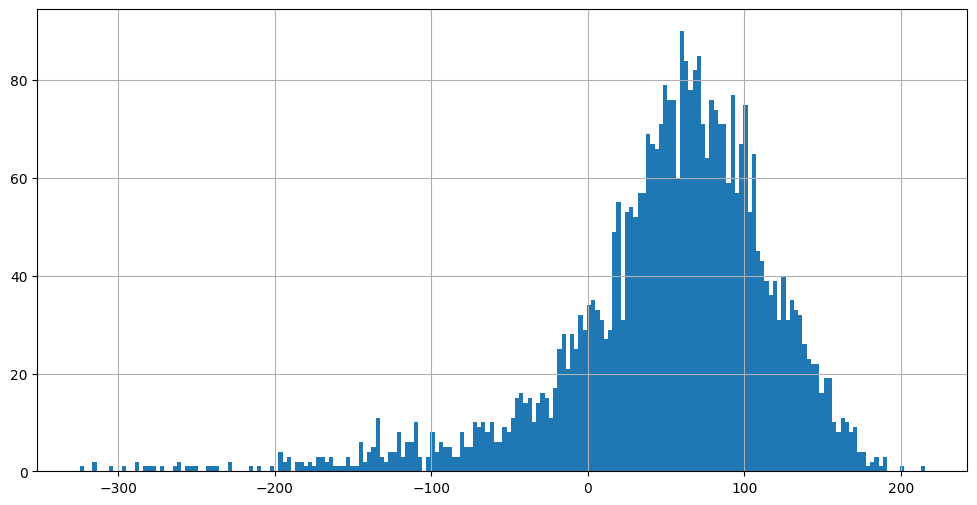

In [ ]:
# Hacer un histograma de los valores de diferencia
data_pred['diferencia'].hist(bins=200, figsize=(12, 6))